In [52]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.utils.data as torch_data
import sklearn
from sklearn.metrics import accuracy_score

## Metrics

In [53]:
train_loss_convae = np.load(r'convae_experiments/train_loss_convae.npy')
train_loss_convae_l1 = np.load(r'convae_experiments/train_loss_convae_l1.npy')
train_loss_posconvae = np.load(r'convae_experiments/train_loss_posconvae.pt.npy')
train_loss_posconvae_l1 = np.load(r'convae_experiments/train_loss_posconvae_l1.npy')

val_loss_convae = np.load(r'convae_experiments/val_loss_convae.npy')
val_loss_convae_l1 = np.load(r'convae_experiments/val_loss_convae_l1.npy')
val_loss_posconvae = np.load(r'convae_experiments/val_loss_posconvae.pt.npy')
val_loss_posconvae_l1 = np.load(r'convae_experiments/val_loss_posconvae_l1.npy')

train_accs_convae = np.load(r'convae_experiments/train_acc_convae.npy')
train_accs_convae_l1 = np.load(r'convae_experiments/train_acc_convae_l1.npy')
train_accs_posconvae = np.load(r'convae_experiments/train_acc_posconvae.pt.npy')
train_accs_posconvae_l1 = np.load(r'convae_experiments/train_acc_posconvae_l1.npy')

val_accs_convae = np.load(r'convae_experiments/val_acc_convae.npy')
val_accs_convae_l1 = np.load(r'convae_experiments/val_acc_convae_l1.npy')
val_accs_posconvae = np.load(r'convae_experiments/val_acc_posconvae.pt.npy')
val_accs_posconvae_l1 = np.load(r'convae_experiments/val_acc_posconvae_l1.npy')

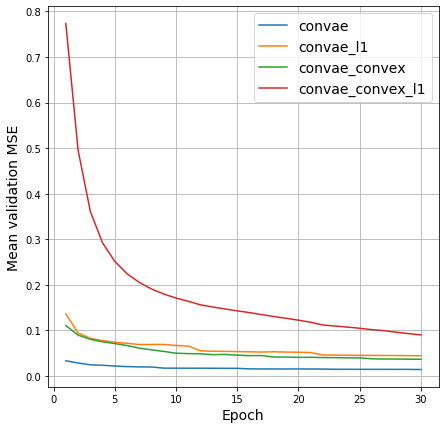

In [81]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

axs.grid()
axs.plot(np.arange(1, 31), val_loss_convae, label="convae")
axs.plot(np.arange(1, 31), val_loss_convae_l1, label="convae_l1")
axs.plot(np.arange(1, 31), val_loss_posconvae, label="convae_convex")
axs.plot(np.arange(1, 31), val_loss_posconvae_l1, label="convae_convex_l1")
axs.set_xlabel("Epoch", fontsize=14)
axs.set_ylabel("Mean validation MSE", fontsize=14)
axs.legend(fontsize=14)
plt.show()

## Sparsities

In [29]:
class Dense(nn.Linear):
    def __init__(self, *args,**kwargs):
        super(Dense, self).__init__(*args,**kwargs)
    
    def get_sparsity(self):
        data = self.weight.data
        return (data == 0).sum().item() / (data.shape[0] * data.shape[1])
    
    def l1reg(self, device='cpu'):
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for name, W in self.named_parameters():
            l1_reg = l1_reg + W.norm(1)
        return l1_reg

class PosDense(nn.Linear):
    def __init__(self, *args,**kwargs):
        super(PosDense, self).__init__(*args,**kwargs)
    
    def positivate(self):
        self.weight.data = F.relu(self.weight.data)
    
    def get_sparsity(self):
        data = self.weight.data
        return (data == 0).sum().item() / (data.shape[0] * data.shape[1])
    
    def l1reg(self, device):
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for name, W in self.named_parameters():
            l1_reg = l1_reg + W.norm(1)
        return l1_reg

class PosConv2d(nn.Conv2d):
    def __init__(self, *args,**kwargs):
        super(PosConv2d, self).__init__(*args,**kwargs)
    
    def positivate(self):
        self.weight.data = F.relu(self.weight.data)


In [30]:
class AutoEncoder(nn.Module):

    def __init__(self, code_size):
        super().__init__()
        self.code_size = code_size

        # Encoder specification
        self.enc_cnn_1 = PosConv2d(INPUT_CHANNELS, 5, kernel_size=5)
        self.enc_cnn_2 = PosConv2d(5, 10, kernel_size=5)
        self.enc_linear_1 = PosDense(10 * 13 * 13, 800)
        self.enc_linear_2 = PosDense(800, self.code_size)

        # Decoder specification
        self.dec_linear_1 = PosDense(self.code_size, 4000)
        self.dec_linear_2 = Dense(4000, IMAGE_SIZE * INPUT_CHANNELS)

    def forward(self, images):
        code = self.encode(images)
        out = self.decode(code)
        return out, code

    def encode(self, images):
        code = self.enc_cnn_1(images)
        code = F.selu(F.max_pool2d(code, 2))

        code = self.enc_cnn_2(code)
        code = F.selu(F.max_pool2d(code, 2))

        code = code.view([images.size(0), -1])
        code = F.selu(self.enc_linear_1(code))
        code = self.enc_linear_2(code)
        return code

    def decode(self, code):
        out = F.selu(self.dec_linear_1(code))
        out = F.selu(self.dec_linear_2(out))
        out = out.view([code.size(0), INPUT_CHANNELS,
                        IMAGE_WIDTH, IMAGE_HEIGHT])
        return out

    def positivate(self):
        self.enc_cnn_1.positivate()
        self.enc_cnn_2.positivate()
        self.enc_linear_1.positivate()

    def l1reg(self, device):
        return self.enc_linear_1.l1reg(device) + \
               self.enc_linear_2.l1reg(device) + \
               self.dec_linear_1.l1reg(device) + \
               self.dec_linear_2.l1reg(device)


In [41]:
code_size = 500
INPUT_CHANNELS = 3
IMAGE_SIZE = 64 * 64

convae = AutoEncoder(code_size)
convae.load_state_dict(torch.load(r'convae_experiments/convae', map_location=torch.device('cpu')))

convae_l1 = AutoEncoder(code_size)
convae_l1.load_state_dict(torch.load(r'convae_experiments/convae_l1', map_location=torch.device('cpu')))

posconvae = AutoEncoder(code_size)
posconvae.load_state_dict(torch.load(r'convae_experiments/posconvae.pt', map_location=torch.device('cpu')))

posconvae_l1 = AutoEncoder(code_size)
posconvae_l1.load_state_dict(torch.load(r'convae_experiments/posconvae_l1', map_location=torch.device('cpu')))


<All keys matched successfully>

In [65]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [66]:
def net_sparsities(net):
    total_param = count_parameters(net)
    res = {'enc' : 
            {
                'fc_1' : net.enc_linear_1.get_sparsity() * count_parameters(net.enc_linear_1) / total_param,
                'fc_2' : net.enc_linear_2.get_sparsity()
            },
           'dec' :
            {
                'fc_1' : net.dec_linear_1.get_sparsity(),
                'fc_2' : net.dec_linear_2.get_sparsity()  
            }
          }
    return res
        

In [67]:
net_sparsities(convae)

{'enc': {'fc_1': 0.0, 'fc_2': 0.0}, 'dec': {'fc_1': 0.0, 'fc_2': 0.0}}

In [68]:
net_sparsities(convae_l1)

{'enc': {'fc_1': 0.0, 'fc_2': 0.0}, 'dec': {'fc_1': 0.0, 'fc_2': 0.0}}

In [69]:
net_sparsities(posconvae)

{'enc': {'fc_1': 0.002961756113645227, 'fc_2': 0.0},
 'dec': {'fc_1': 0.0, 'fc_2': 0.0}}

In [70]:
net_sparsities(posconvae_l1)

{'enc': {'fc_1': 0.01163046968368158, 'fc_2': 0.0},
 'dec': {'fc_1': 0.0, 'fc_2': 0.0}}